# 3章 情報の圧縮と表現

## 事前準備

In [1]:
!curl -L -o genaibook.zip https://github.com/oreilly-japan/hands-on-generative-ai-ja/releases/download/genaibook/genaibook.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  4678  100  4678    0     0  14515      0 --:--:-- --:--:-- --:--:-- 14515


In [2]:
!unzip genaibook.zip

Archive:  genaibook.zip
Made with MacWinZipper (http://tidajapan.com/macwinzipper)
  inflating: genaibook/__init__.py   
  inflating: genaibook/core.py       


In [3]:
!pip install evaluate jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 107.6 MB/s eta 0:00:00


In [4]:
!pip install datasets==4.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 68.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


## オートエンコーダー

### データの準備

In [1]:
from datasets import load_dataset

mnist = load_dataset("ylecun/mnist")
mnist

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [2]:
mnist["train"]["image"][1]

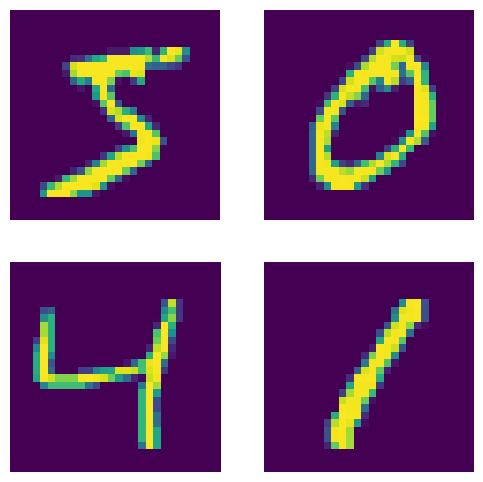

In [3]:
from genaibook.core import show_images

show_images(mnist["train"]["image"][:4])

In [ ]:
import matplotlib as mpl

mpl.rcParams["image.cmap"] = "gray_r"

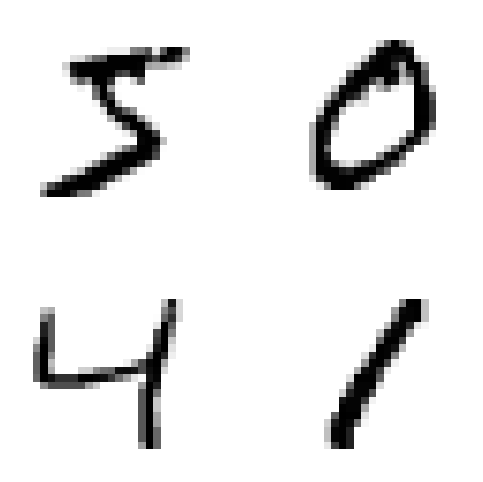

In [ ]:
show_images(mnist["train"]["image"][:4])

In [ ]:
import torch

torch.manual_seed(1337);

In [ ]:
from torchvision import transforms


def mnist_to_tensor(samples):
    t = transforms.ToTensor()
    samples["image"] = [t(image) for image in samples["image"]]
    return samples

In [ ]:
mnist = mnist.with_transform(mnist_to_tensor)
mnist["train"] = mnist["train"].shuffle(seed=1337)

In [ ]:
x = mnist["train"]["image"][0]
x.min(), x.max()

(tensor(0.), tensor(1.))

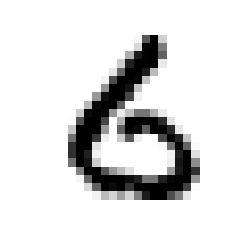

In [ ]:
show_images(mnist["train"]["image"][0])

In [ ]:
from torch.utils.data import DataLoader

bs = 64
train_dataloader = DataLoader(mnist["train"]["image"], batch_size=bs)

### エンコーダーのモデリング

In [ ]:
from torch import nn


def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 256)
        self.conv3 = conv_block(256, 512)
        self.conv4 = conv_block(512, 1024)
        self.linear = nn.Linear(1024, 16)

    def forward(self, x):
        x = self.conv1(x)  # (batch size, 128, 14, 14)
        x = self.conv2(x)  # (bs, 256, 7, 7)
        x = self.conv3(x)  # (bs, 512, 3, 3)
        x = self.conv4(x)  # (bs, 1024, 1, 1)
        # バッチの次元数を保持したまま平坦化する
        x = self.linear(x.flatten(start_dim=1))  # (bs, 16)
        return x

In [ ]:
mnist["train"]["image"][0].shape

torch.Size([1, 28, 28])

In [ ]:
in_channels = 1

x = mnist["train"]["image"][0][None, :]
encoder = Encoder(in_channels).eval()

encoded = encoder(x)
encoded.shape

torch.Size([1, 16])

In [ ]:
encoded

tensor([[-0.0145, -0.0318, -0.0109,  0.0080, -0.0218,  0.0305,  0.0183, -0.0294,
          0.0075,  0.0178, -0.0161, -0.0018,  0.0208, -0.0079,  0.0215,  0.0101]],
       grad_fn=<AddmmBackward0>)

In [ ]:
batch = next(iter(train_dataloader))
encoded = Encoder(in_channels=1)(batch)
batch.shape, encoded.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 16]))

### デコーダー

In [ ]:
def conv_transpose_block(
    in_channels,
    out_channels,
    kernel_size=3,
    stride=2,
    padding=1,
    output_padding=0,
    with_act=True,
):
    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
        ),
    ]
    if with_act:  # 後々のことを考えて制御できるようにしておく
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())
    return nn.Sequential(*modules)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.linear = nn.Linear(
            16, 1024 * 4 * 4
        )  # forward内で形状が変化している点に注意
        self.t_conv1 = conv_transpose_block(1024, 512)
        self.t_conv2 = conv_transpose_block(512, 256, output_padding=1)
        self.t_conv3 = conv_transpose_block(256, out_channels, output_padding=1)

    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)  # (bs, 1024*4*4)
        x = x.reshape((bs, 1024, 4, 4))  # (bs, 1024, 4, 4)
        x = self.t_conv1(x)  # (bs, 512, 7, 7)
        x = self.t_conv2(x)  # (bs, 256, 14, 14)
        x = self.t_conv3(x)  # (bs, 1, 28, 28)
        return x

In [ ]:
decoded_batch = Decoder(x.shape[0])(encoded)
decoded_batch.shape

torch.Size([64, 1, 28, 28])

### 訓練

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.encoder = Encoder(in_channels)
        self.decoder = Decoder(in_channels)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))

In [ ]:
model = AutoEncoder(1)

In [ ]:
import torchsummary

torchsummary.summary(model, input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                   [-1, 16]          16,400
          Encoder-14                   

In [ ]:
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from tqdm.notebook import tqdm, trange

from genaibook.core import get_device

num_epochs = 10
lr = 1e-4

device = get_device()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

losses = []  # 描画用に損失を保存するリスト
for _ in (progress := trange(num_epochs, desc="Training")):
    for _, batch in (
        inner := tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    ):
        batch = batch.to(device)

        # モデルに渡して再構成画像を取得する
        preds = model(batch)

        # 予測結果と元画像を比較する
        loss = F.mse_loss(preds, batch)

        # 損失を表示し、描画用に保存する
        inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
        losses.append(loss.item())

        # 損失に基づいてモデルのパラメーターを更新する
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

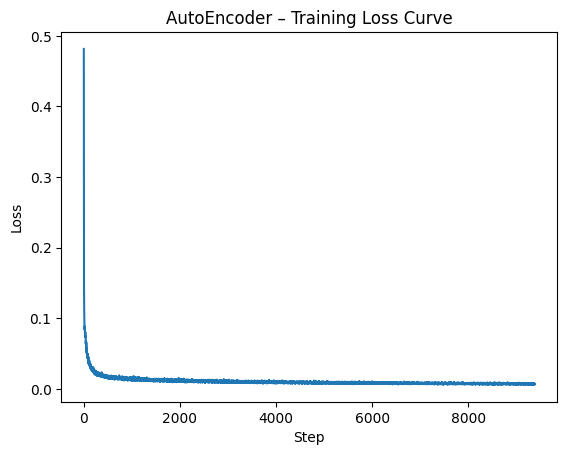

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("AutoEncoder – Training Loss Curve")
plt.show()

In [ ]:
eval_bs = 16
eval_dataloader = DataLoader(mnist["test"]["image"], batch_size=eval_bs)

In [ ]:
model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = model(eval_batch.to(device)).cpu()

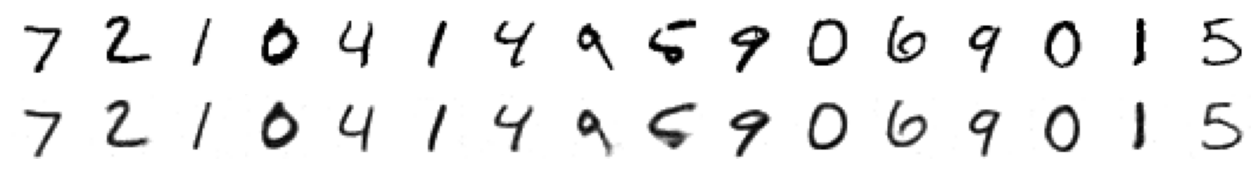

In [ ]:
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

### 潜在空間の探索

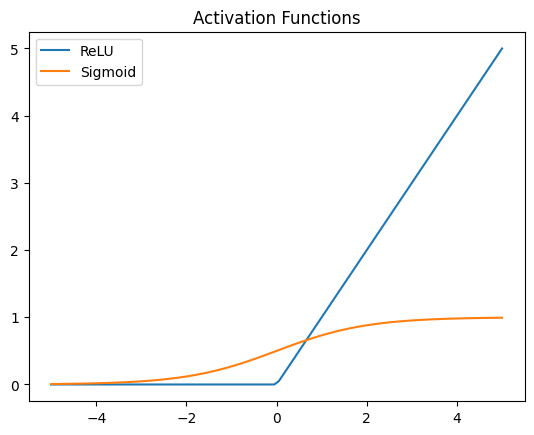

In [ ]:
def plot_activation_fn(fn, name):
    x = torch.linspace(-5, 5, 100)
    y = fn(x)
    plt.plot(x, y, label=name)
    plt.legend()


plt.title("Activation Functions")
plot_activation_fn(F.relu, "ReLU")
plot_activation_fn(F.sigmoid, "Sigmoid")

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()

        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024),
        )
        self.linear = nn.Linear(1024, latent_dims)

    def forward(self, x):
        bs = x.shape[0]
        x = self.conv_layers(x)
        x = self.linear(x.reshape(bs, -1))
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, out_channels, latent_dims):
        super().__init__()

        self.linear = nn.Linear(latent_dims, 1024 * 4 * 4)
        self.t_conv_layers = nn.Sequential(
            conv_transpose_block(1024, 512),
            conv_transpose_block(512, 256, output_padding=1),
            conv_transpose_block(
                256, out_channels, output_padding=1, with_act=False
            ),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)
        x = x.reshape((bs, 1024, 4, 4))
        x = self.t_conv_layers(x)
        x = self.sigmoid(x)
        return x

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()
        self.encoder = Encoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels, latent_dims)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))

In [ ]:
def train(model, num_epochs=10, lr=1e-4):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

    model.train()  # モデルを訓練モードに設定する
    losses = []
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (
            inner := tqdm(
                enumerate(train_dataloader), total=len(train_dataloader)
            )
        ):
            batch = batch.to(device)

            # モデルに渡して別の画像セットを取得する
            preds = model(batch)

            # 予測結果と元画像を比較する
            loss = F.mse_loss(preds, batch)

            # 損失を表示し、描画用に保存する
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses.append(loss.item())

            # 損失に基づいてモデルのパラメーターを更新する
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses

In [ ]:
ae_model = AutoEncoder(in_channels=1, latent_dims=2)
ae_model.to(device)

AutoEncoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (linear): Linear(in_

In [ ]:
losses = train(ae_model)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

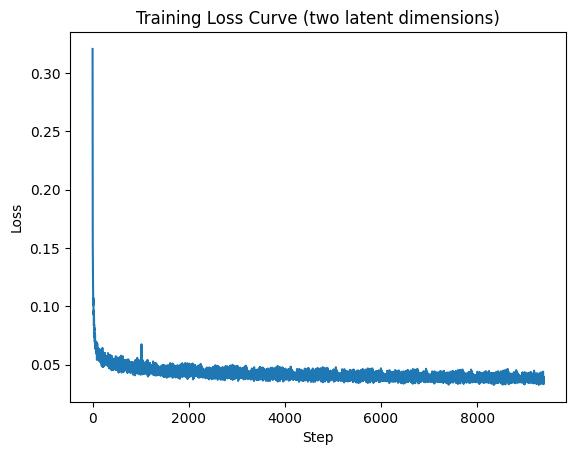

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve (two latent dimensions)")
plt.show()

In [ ]:
ae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = ae_model(eval_batch.to(device)).cpu()

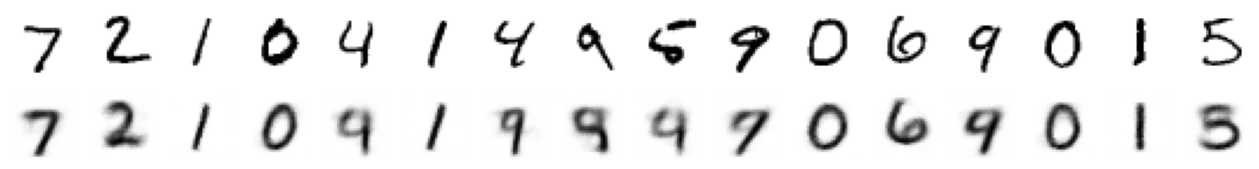

In [ ]:
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

### 潜在空間の可視化

In [ ]:
images_labels_dataloader = DataLoader(mnist["test"], batch_size=512)

In [ ]:
import pandas as pd

df = pd.DataFrame(
    {
        "x": [],
        "y": [],
        "label": [],
    }
)

for batch in tqdm(
    iter(images_labels_dataloader), total=len(images_labels_dataloader)
):
    encoded = ae_model.encode(batch["image"].to(device)).cpu()
    new_items = {
        "x": [t.item() for t in encoded[:, 0]],
        "y": [t.item() for t in encoded[:, 1]],
        "label": batch["label"],
    }
    df = pd.concat([df, pd.DataFrame(new_items)], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

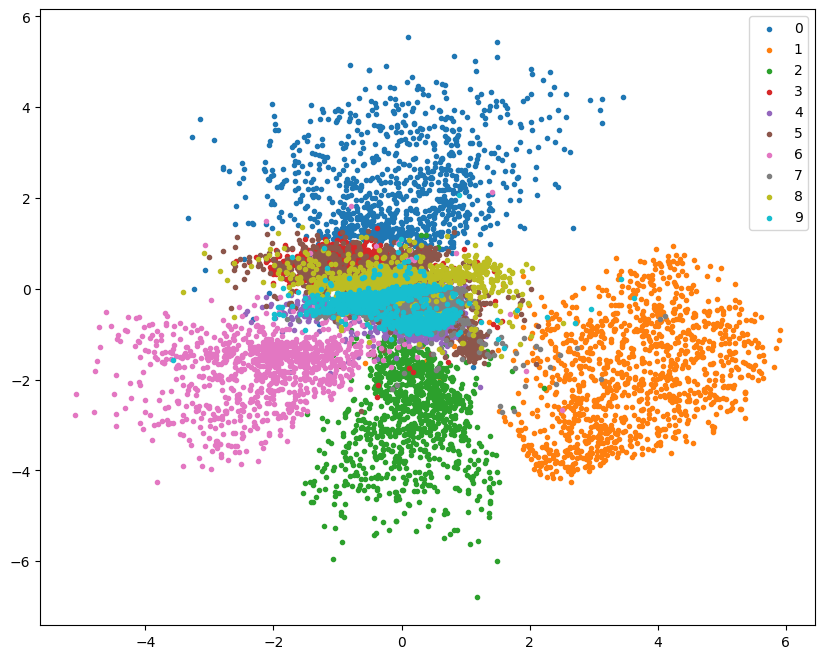

In [ ]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.legend();

In [ ]:
N = 16  # 16個の点を生成する
z = torch.rand((N, 2)) * 8 - 4

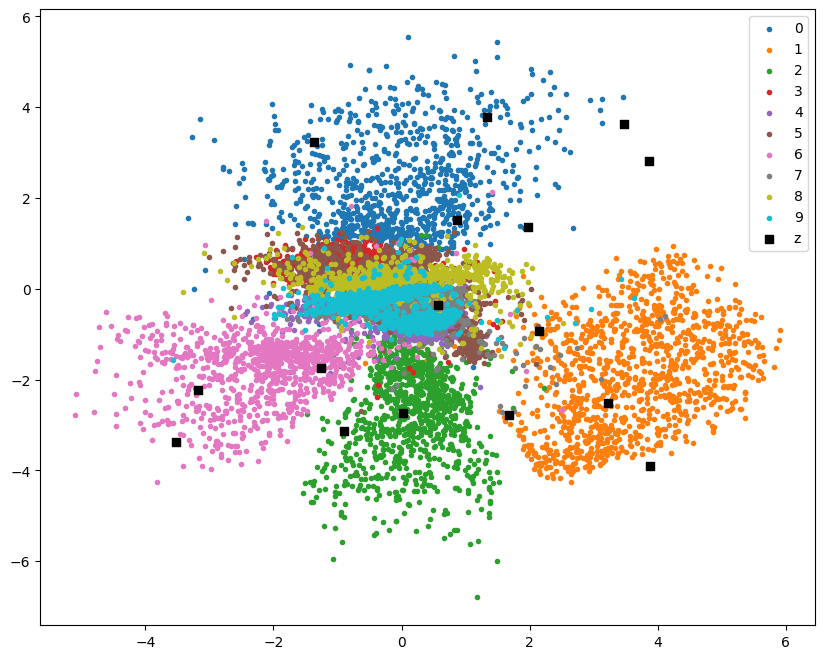

In [ ]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.scatter(z[:, 0], z[:, 1], label="z", marker="s", color="black")
plt.legend();

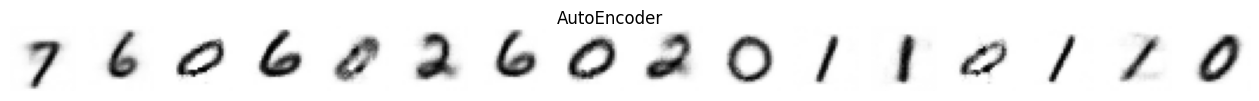

In [ ]:
ae_decoded = ae_model.decode(z.to(device))
show_images(ae_decoded.cpu(), imsize=1, nrows=1, suptitle="AutoEncoder")

## 変分オートエンコーダー（VAE）

### VAEエンコーダーとデコーダー

In [ ]:
class VAEEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()

        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024),
        )

        # 全結合層を定義して平均と対数分散を求める
        self.mu = nn.Linear(1024, latent_dims)
        self.logvar = nn.Linear(1024, latent_dims)

    def forward(self, x):
        bs = x.shape[0]
        x = self.conv_layers(x)
        x = x.reshape(bs, -1)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return (mu, logvar)

In [ ]:
class VAE(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()
        self.encoder = VAEEncoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels, latent_dims)

    def encode(self, x):
        # mu と log_var を返す
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # 正規分布（ガウス分布）のパラメータを取得する
        mu, logvar = self.encode(x)

        # 分布からサンプリングする
        std = torch.exp(0.5 * logvar)
        z = self.sample(mu, std)

        # 潜在変数をピクセル空間にデコードする
        reconstructed = self.decode(z)

        # 再構成画像に加え、mu と logvar も返す
        # これにより分布の損失を計算できる
        return reconstructed, mu, logvar

    def sample(self, mu, std):
        # 再パラメータ化のトリック
        # N(0, I)からサンプルし、平行移動、スケールする
        eps = torch.randn_like(std)
        return mu + eps * std

### VAEの訓練

In [ ]:
def vae_loss(batch, reconstructed, mu, logvar):
    bs = batch.shape[0]

    # 再構成損失
    reconstruction_loss = F.mse_loss(
        reconstructed.reshape(bs, -1),
        batch.reshape(bs, -1),
        reduction="none",
    ).sum(dim=-1)

    # KLD
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    # 2つの損失を合計し、画像全体で平均をとる
    loss = (reconstruction_loss + kl_loss).mean(dim=0)

    return (loss, reconstruction_loss, kl_loss)

In [ ]:
def train_vae(model, num_epochs=10, lr=1e-4):
    model = model.to(device)
    losses = {
        "loss": [],
        "reconstruction_loss": [],
        "kl_loss": [],
    }

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (
            inner := tqdm(
                enumerate(train_dataloader), total=len(train_dataloader)
            )
        ):
            batch = batch.to(device)

            # モデルに渡して結果を得る
            reconstructed, mu, logvar = model(batch)

            # 損失を計算する
            loss, reconstruction_loss, kl_loss = vae_loss(
                batch, reconstructed, mu, logvar
            )

            # 損失を表示し、描画用に保存する
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses["loss"].append(loss.item())
            losses["reconstruction_loss"].append(
                reconstruction_loss.mean().item()
            )
            losses["kl_loss"].append(kl_loss.mean().item())

            # 総損失に基づいてモデルのパラメーターを更新する
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses
vae_model = VAE(in_channels=1, latent_dims=2)
losses = train_vae(vae_model, num_epochs=10, lr=1e-4)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

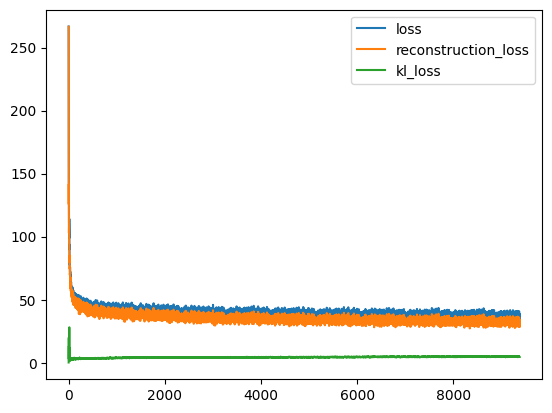

In [ ]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend();

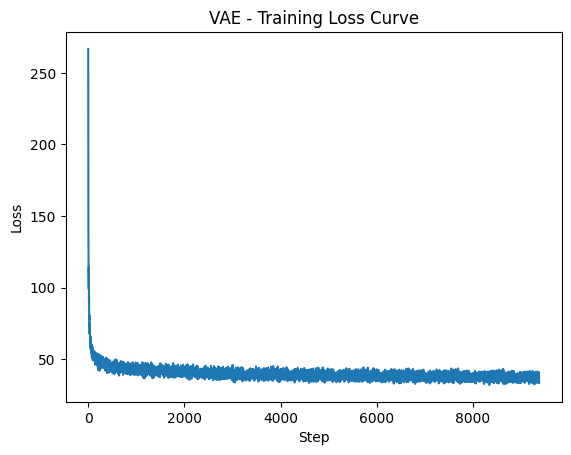

In [ ]:
plt.plot(losses["loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE - Training Loss Curve")
plt.show()

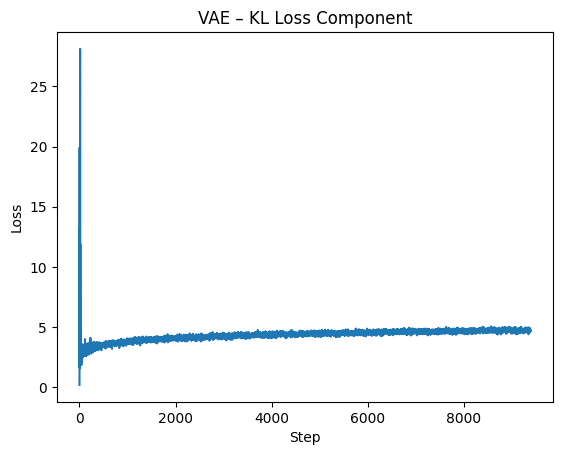

In [ ]:
plt.plot(losses["kl_loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE – KL Loss Component")
plt.show()

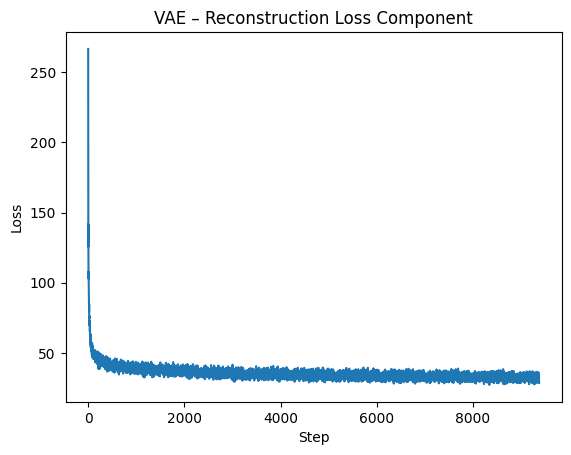

In [ ]:
plt.plot(losses["reconstruction_loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE – Reconstruction Loss Component")
plt.show()

In [ ]:
vae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted, mu, logvar = (v.cpu() for v in vae_model(eval_batch.to(device)))

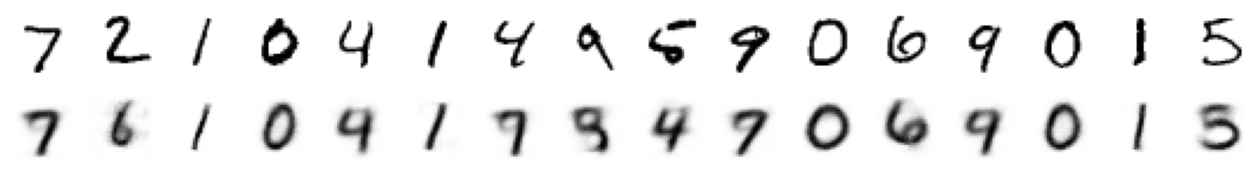

In [ ]:
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

In [ ]:
df = pd.DataFrame(
    {
        "x": [],
        "y": [],
        "label": [],
    }
)

for batch in tqdm(
    iter(images_labels_dataloader), total=len(images_labels_dataloader)
):
    mu, _ = vae_model.encode(batch["image"].to(device))
    mu = mu.to("cpu")
    new_items = {
        "x": [t.item() for t in mu[:, 0]],
        "y": [t.item() for t in mu[:, 1]],
        "label": batch["label"],
    }
    df = pd.concat([df, pd.DataFrame(new_items)], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

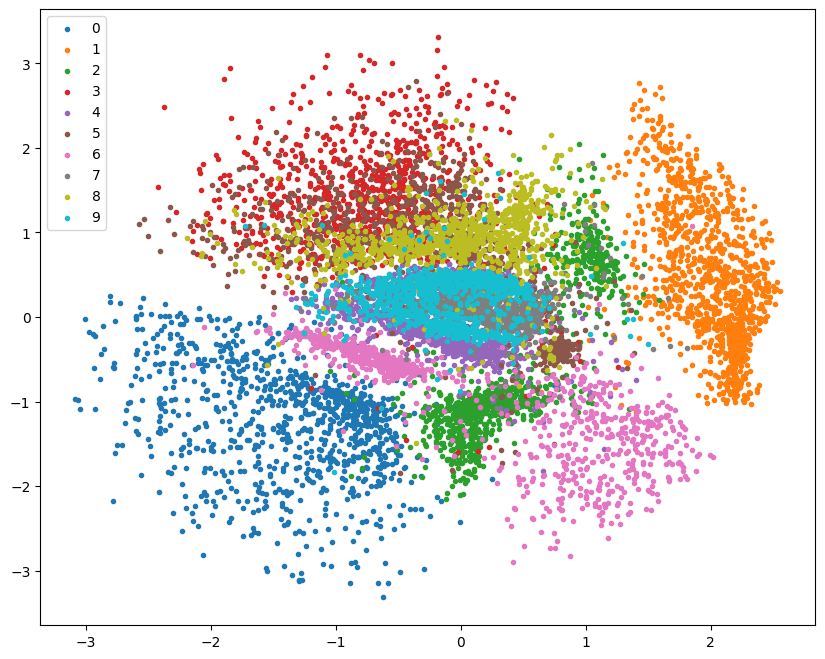

In [ ]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.legend();

In [ ]:
z = torch.normal(0, 1, size=(10, 2))
ae_decoded = ae_model.decode(z.to(device))
vae_decoded = vae_model.decode(z.to(device))

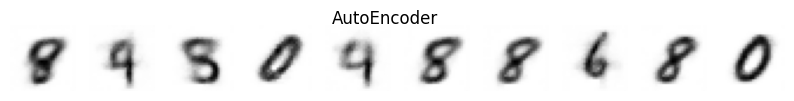

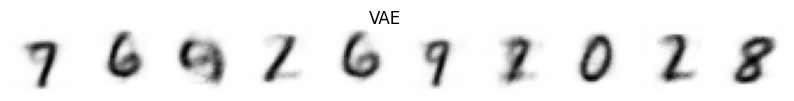

In [ ]:
show_images(ae_decoded.cpu(), imsize=1, nrows=1, suptitle="AutoEncoder")
show_images(vae_decoded.cpu(), imsize=1, nrows=1, suptitle="VAE")

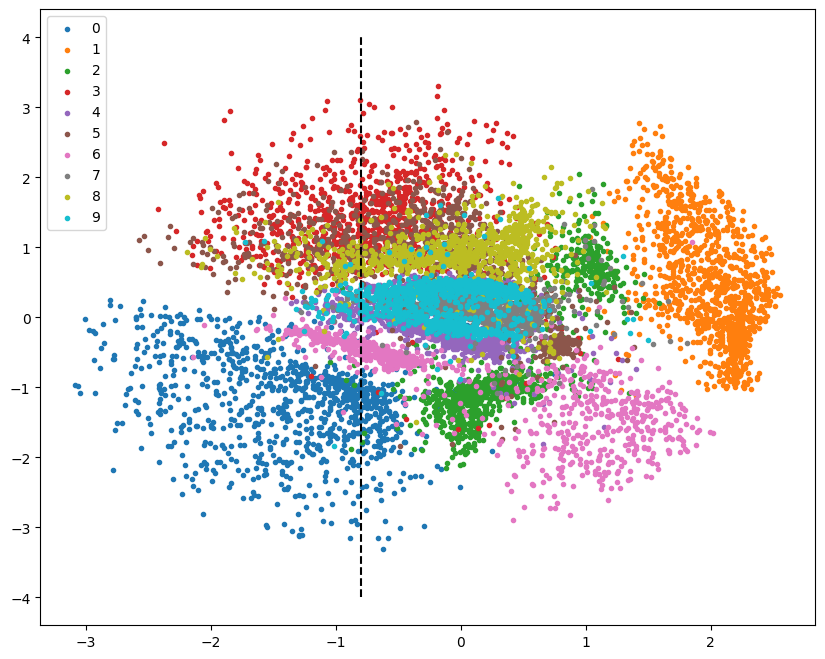

In [ ]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.vlines(-0.8, ymin=-4, ymax=4, linestyle="dashed", colors="black")
plt.legend();

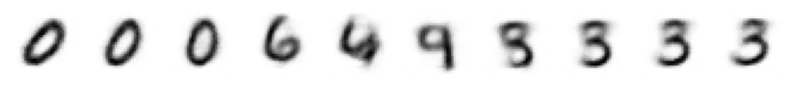

In [ ]:
import numpy as np

with torch.inference_mode():
    inputs = []
    for y in np.linspace(-2, 2, 10):
        inputs.append([-0.8, y])
    z = torch.tensor(inputs, dtype=torch.float32).to(device)
    decoded = vae_model.decode(z)
show_images(decoded.cpu(), imsize=1, nrows=1)

In [ ]:
inputs = []
for x in np.linspace(-2, 2, 20):
    for y in np.linspace(-2, 2, 20):
        inputs.append([x, y])
z = torch.tensor(inputs, dtype=torch.float32).to(device)
decoded = vae_model.to(device).decode(z)

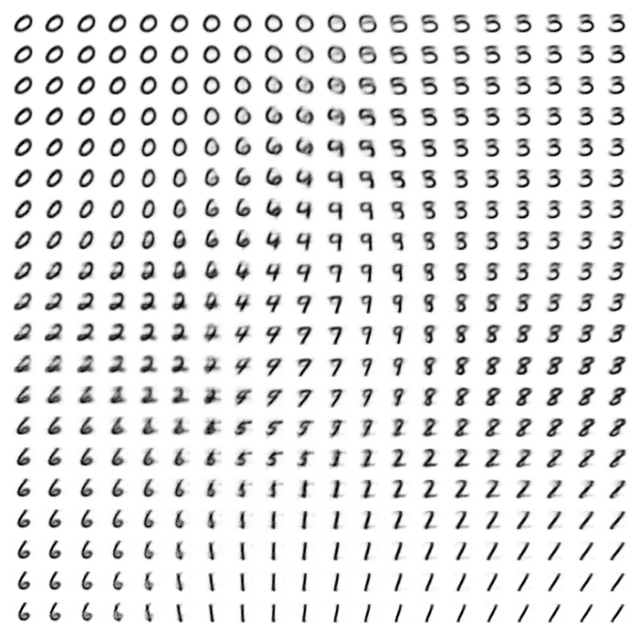

In [ ]:
show_images(decoded.cpu(), imsize=0.4, nrows=20)

## CLIP

### CLIPの利用 ― ステップ・バイ・ステップ

In [ ]:
import requests
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

from genaibook.core import SampleURL

clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

url = SampleURL.LionExample
image = Image.open(requests.get(url, stream=True).raw)

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
image_inputs = processor(images=image, return_tensors="pt")
pixel_values = image_inputs["pixel_values"]
pixel_values.shape, pixel_values.min(), pixel_values.max()

(torch.Size([1, 3, 224, 224]), tensor(-1.7923), tensor(1.9895))

In [ ]:
processor.image_processor

CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

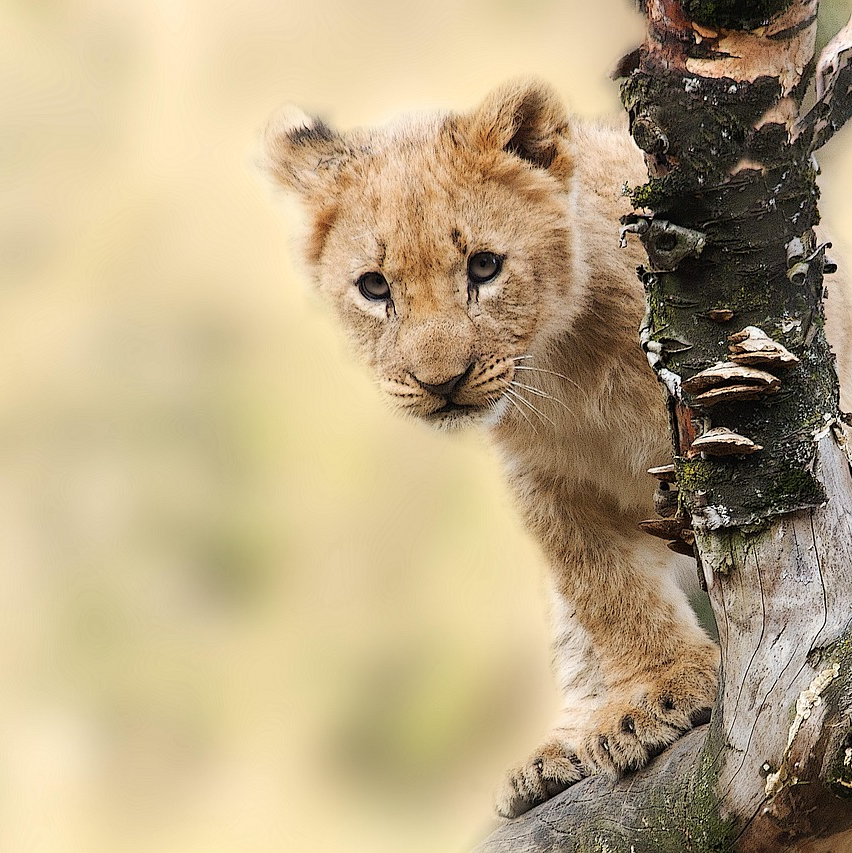

In [ ]:
width, height = image.size
crop_length = min(image.size)

left = (width - crop_length) / 2
top = (height - crop_length) / 2
right = (width + crop_length) / 2
bottom = (height + crop_length) / 2

cropped = image.crop((left, top, right, bottom))
cropped

In [ ]:
with torch.inference_mode():
    output = clip.vision_model(pixel_values.to(device))
image_embeddings = output.pooler_output
image_embeddings.shape

torch.Size([1, 1024])

In [ ]:
prompts = [
    "a photo of a lion",
    "a photo of a zebra",
]

# すべての入力が同じ長さになるようパディングする
text_inputs = processor(text=prompts, return_tensors="pt", padding=True)
text_inputs

{'input_ids': tensor([[49406,   320,  1125,   539,   320,  5567, 49407],
        [49406,   320,  1125,   539,   320, 22548, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

with torch.inference_mode():
    text_output = clip.text_model(**text_inputs)

In [ ]:
text_embeddings = text_output.pooler_output
text_embeddings.shape

torch.Size([2, 768])

In [ ]:
print(clip.text_projection)
print(clip.visual_projection)

Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=1024, out_features=768, bias=False)


In [ ]:
with torch.inference_mode():
    text_embeddings = clip.text_projection(text_embeddings)
    image_embeddings = clip.visual_projection(image_embeddings)
text_embeddings.shape, image_embeddings.shape

(torch.Size([2, 768]), torch.Size([1, 768]))

In [ ]:
text_embeddings = text_embeddings / text_embeddings.norm(
    p=2, dim=-1, keepdim=True
)
image_embeddings = image_embeddings / image_embeddings.norm(
    p=2, dim=-1, keepdim=True
)

In [ ]:
similarities = torch.matmul(text_embeddings, image_embeddings.T)
similarities

tensor([[0.2226],
        [0.1936]], device='cuda:0')

In [ ]:
similarities = 100 * torch.matmul(text_embeddings, image_embeddings.T)
similarities.softmax(dim=0).cpu()

tensor([[0.9479],
        [0.0521]])

### CLIPによるゼロショット画像分類

In [ ]:
clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

image = Image.open(requests.get(SampleURL.LionExample, stream=True).raw)

In [ ]:
prompts = [
    "a photo of a lion",
    "a photo of a zebra",
    "a photo of a cat",
    "a photo of an adorable lion cub",
    "a puppy",
    "a lion behind a branch",
]
inputs = processor(
    text=prompts, images=image, return_tensors="pt", padding=True
)
inputs = {k: v.to(device) for k, v in inputs.items()}

outputs = clip(**inputs)
logits_per_image = outputs.logits_per_image
probabilities = logits_per_image.softmax(dim=1)

In [ ]:
probabilities = probabilities[0].cpu().detach().tolist()

In [ ]:
for prob, prompt in sorted(zip(probabilities, prompts), reverse=True):
    print(f"{100*prob: =2.0f}%: {prompt}")

84%: a photo of an adorable lion cub
13%: a lion behind a branch
 3%: a photo of a lion
 0%: a photo of a zebra
 0%: a photo of a cat
 0%: a puppy


### ゼロショット画像分類パイプライン

In [ ]:
from transformers import pipeline

classifier = pipeline(
    "zero-shot-image-classification",
    model="openai/clip-vit-large-patch14",
    device=device,
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda


In [ ]:
scores = classifier(
    image,
    candidate_labels=prompts,
    hypothesis_template="{}",
)

In [ ]:
print(scores)

[{'score': 0.8392898440361023, 'label': 'a photo of an adorable lion cub'}, {'score': 0.12918123602867126, 'label': 'a lion behind a branch'}, {'score': 0.029192272573709488, 'label': 'a photo of a lion'}, {'score': 0.0016057785833254457, 'label': 'a photo of a zebra'}, {'score': 0.0007013388094492257, 'label': 'a photo of a cat'}, {'score': 2.952101749542635e-05, 'label': 'a puppy'}]
